# PolyQ Rotamers Analysis - Q1E_DES-amber 

### Libraries of interest 

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import pandas as pd
import mdtraj as md
import scipy.stats as st
import nglview as nv
import MDAnalysis as mda
from nglview.datafiles import PDB,XTC
from scipy.spatial.distance import cdist
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import cm
#from scipy.stats import gaussian_kde
from Bio.SeqUtils import IUPACData
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools
import mdtraj.testing
from itertools import product

### Kernel density estimation

In [2]:
class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

### Upload the trajectories

First, we uploaded the topology (trajectory and pdb) and saved as "t". 

In [3]:
dirname = f'/home/lourdes/TFM-LOURDES/data/ALL/Q1E_DES-amber'
temp = 1 
equil = 0
topname = os.path.join(dirname, 'prot.pdb')
trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
t = md.load(trajname, top=topname, stride=1)
t = t[equil:]
t.remove_solvent(inplace=True)
print (t)

<mdtraj.Trajectory with 18877 frames, 411 atoms, 24 residues, and unitcells>


### Secondary structure: Helicity 

When we have the topology, we can calculate the helicity (secondary structure of each amino acid) using the "md.compute_dssp" function. We have obtained an array (nº of frames, nº of residues) with "H" or 1 when the residue is helical and "C" or 0 when the residue is coil.  

In [4]:
####HELICITY
ss = md.compute_dssp(t,simplified=True)
ssh = (ss=='H').astype(np.float)
ssc = (ss=='C').astype(np.float)

print (ssh.shape)
print (ssc.shape)

print (ssh)
print (ssc)

(18877, 24)
(18877, 24)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


### Selection of new trajectories/topologies of interest 

Now we can also select the frames where a determinated condition is fullfiled. For example, we are going to focus our studies in the different rotamers population depending on whether the residues are helical or not/are forming the sc-mc hydrogen bond or not. 

In [5]:
#select some different trajectories 

# new trajectory where the residues 7 to 14 are helical 
t_helix = t[np.all(ssh[:,6:13]>0,1)]
print (t_helix)


# new trajectory where the residues 17 to 20 are not helical (coil)
t_coil = t[np.all(ssc[:,16:19]>0,1)]
print (t_coil)


<mdtraj.Trajectory with 4320 frames, 411 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 13353 frames, 411 atoms, 24 residues, and unitcells>


### Helical L3-Q3 distance: hydrogen bond formation when Q3 is helical 

In [6]:
#Calculate the distance between the Q1 (sc) and L1 (mc)
#These are the potential donor atom names.
#Selecting the hydrogens of Q1
donors_helix = t_helix.topology.select('residue 13 and name HE1 HE2 HE21 HE22')
if donors_helix.size==0: 
    np.array([9999.])
#Selecting the oxigen of L1
acceptor_helix = t_helix.topology.select('residue 9 and name O')
pairs_helix = list(product(donors_helix, acceptor_helix))
d_helix = md.compute_distances(t_helix, pairs_helix)
#We take the shortest distance
d_helix = d_helix.min(1)
d_helix *= 10 #to angstroms

print (d_helix)
print (len(d_helix))

[3.960114  4.574246  4.9906416 ... 1.9028678 2.4634507 1.9744884]
4320


In [40]:
# new trajectory where the L3-Q3 distance is < 2.4A (hydrogen bond is formed) && Q3 (residue11) is helical 
t_hhbond = t_helix[d_helix<2.4]
print(t_hhbond)

# new trajectory where the L1-Q1 distance is > 2.4A (hydrogen bond is NOT formed) && Q1 (residue11) is helical
t_helix_nonhbond = t_helix[d_helix>2.4]
print(t_helix_nonhbond)

<mdtraj.Trajectory with 490 frames, 411 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 3830 frames, 411 atoms, 24 residues, and unitcells>


In [33]:
#Selection of atom L3/L1 of helical trajectories --> t_helix
L3_helix = t_helix.topology.select('residue 9')
t_helix_L3 = t_helix.atom_slice(L3_helix) # trajectoria con unicamente 1 residuo 
print (t_helix_L3)
L1_helix = t_helix.topology.select('residue 7')
t_helix_L1 = t_helix.atom_slice(L1_helix)
print(t_helix_L1)

# Selection of atom L3/L1 of sc-mc hbond (L3-Q3) && helical trajectories --> t_helix_hbond
L3_hhbond = t_hhbond.topology.select('residue 9')
t_hhbond_L3 = t_hhbond.atom_slice(L3_hhbond)
print(t_hhbond_L3)
L1_hhbond = t_hhbond.topology.select('residue 7')
t_hhbond_L1 = t_hhbond.atom_slice(L1_hhbond)
print(t_hhbond_L1)

<mdtraj.Trajectory with 4320 frames, 19 atoms, 1 residues, and unitcells>
<mdtraj.Trajectory with 4320 frames, 19 atoms, 1 residues, and unitcells>
<mdtraj.Trajectory with 456 frames, 19 atoms, 1 residues, and unitcells>
<mdtraj.Trajectory with 456 frames, 19 atoms, 1 residues, and unitcells>


### Dihedrals Calculations for different conditions

Now we are interesting in how the rotamers vary depending on whether the residue is helical or not/is forming a hydrogen bond or not

In [34]:
# Compute the chi angles of residues L1/L3 when the residues from 8 to 11 (9 to 12 starting in 0) are helical  

# RESIDUE 9 --> t_helix_L3
chis1_L3_helix = md.compute_chi1(t_helix_L3)[1]
chis1_L3_helix = np.rad2deg(np.where(chis1_L3_helix<0,chis1_L3_helix+2*np.pi,chis1_L3_helix ))
print(chis1_L3_helix)
x = chis1_L3_helix.shape
print(x)
#RESIDUE 7 --> t_helix_L1
chis1_L1_helix = md.compute_chi1(t_helix_L1)[1]
chis1_L1_helix = np.rad2deg(np.where(chis1_L1_helix<0,chis1_L1_helix+2*np.pi,chis1_L1_helix ))
print(chis1_L1_helix)

chis2_L3_helix = md.compute_chi2(t_helix_L3)[1]
chis2_L3_helix = np.rad2deg(np.where(chis2_L3_helix<0,chis2_L3_helix+2*np.pi,chis2_L3_helix ))
#print(chis2_L3_helix)
chis2_L1_helix = md.compute_chi2(t_helix_L1)[1]
chis2_L1_helix = np.rad2deg(np.where(chis2_L1_helix<0,chis2_L1_helix+2*np.pi,chis2_L1_helix ))
#print(chis2_L1_helix)


[[205.15054]
 [190.58946]
 [191.02748]
 ...
 [170.91214]
 [188.64209]
 [185.33319]]
(4320, 1)
[[204.55463]
 [191.46478]
 [285.7146 ]
 ...
 [271.53217]
 [273.3964 ]
 [261.9701 ]]


In [35]:
# Compute the chi angles when the L3-Q3 sc-mc hydrogen bond is happening 

# RESIDUE 9 --> t_hhbond_L3
chis1_L3_hhbond = md.compute_chi1(t_hhbond_L3)[1]
chis1_L3_hhbond = np.rad2deg(np.where(chis1_L3_hhbond<0,chis1_L3_hhbond+2*np.pi,chis1_L3_hhbond ))
#print(chis1_L3_hhbond)
# RESIDUE 7 --> t_hhbond_L1
chis1_L1_hhbond = md.compute_chi1(t_hhbond_L1)[1]
chis1_L1_hhbond = np.rad2deg(np.where(chis1_L1_hhbond<0,chis1_L1_hhbond+2*np.pi,chis1_L1_hhbond ))
#print(chis1_L1_hhbond)

# RESIDUE 9 --> t_hhbond_L3
chis2_L3_hhbond = md.compute_chi2(t_hhbond_L3)[1]
chis2_L3_hhbond = np.rad2deg(np.where(chis2_L3_hhbond<0,chis2_L3_hhbond+2*np.pi,chis2_L3_hhbond ))
#print(chis2_L3_hhbond)
# RESIDUE 7 --> t_hhbond_L1
chis2_L1_hhbond = md.compute_chi2(t_hhbond_L1)[1]
chis2_L1_hhbond = np.rad2deg(np.where(chis2_L1_hhbond<0,chis2_L1_hhbond+2*np.pi,chis2_L1_hhbond ))
#print(chis2_L1_hhbond)


### Visualization of dihedral angles of helical Q1 vs H-bond forming Q1

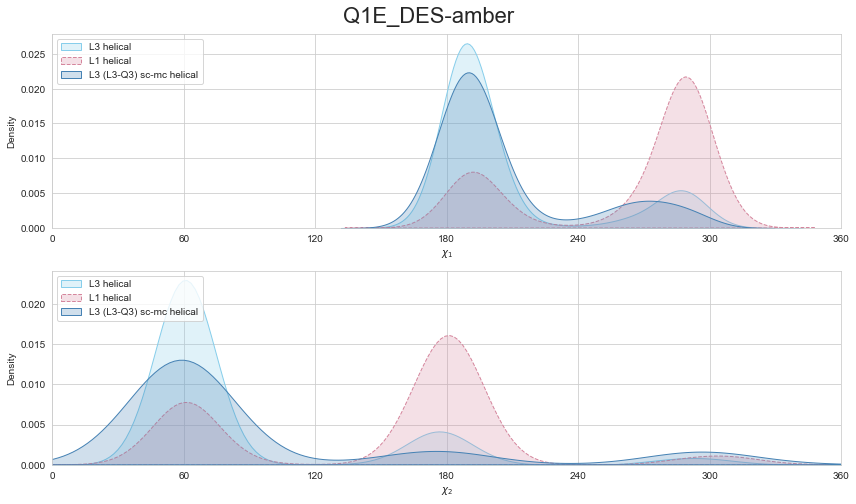

In [36]:
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')
plt.suptitle('Q1E_DES-amber', fontsize=22)
angles = [0,60,120,180,240,300,360] 

plt.subplot(311)
sns.kdeplot(chis1_L3_helix[:,0],shade=True, label="L3 helical", color='skyblue', linestyle="-")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
sns.kdeplot(chis1_L1_helix[:,0],shade=True, label="L1 helical", color='#d5869d', linestyle="--") 
sns.kdeplot(chis1_L3_hhbond[:,0],shade=True, label="L3 (L3-Q3) sc-mc helical", color='steelblue', linestyle="-") 
#sns.kdeplot(chis1_L1_hhbond[:,0],shade=True, label="L1 (L3-Q3) sc-mc helical", color='olivedrab') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_1$');
plt.xlim(0,360)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(chis2_L3_helix[:,0],shade=True, label="L3 helical", color='skyblue', linestyle="-")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
sns.kdeplot(chis2_L1_helix[:,0],shade=True, label="L1 helical", color='#d5869d', linestyle="--") 
sns.kdeplot(chis2_L3_hhbond[:,0],shade=True, label="L3 (L3-Q3) sc-mc helical", color='steelblue', linestyle="-") 
#sns.kdeplot(chis2_L3_hhbond[:,0],shade=True, label="L1 (L3-Q3) sc-mc helical", color='olivedrab') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_2$');
plt.xlim(0,360)
plt.xticks(angles)

plt.tight_layout()




([<matplotlib.axis.XTick at 0x7fec7fcade80>,
 [Text(125.0, 0, '125'),
  Text(150.0, 0, '150'),
  Text(175.0, 0, '175'),
  Text(200.0, 0, '200'),
  Text(225.0, 0, '225'),
  Text(250.0, 0, '250'),
  Text(275.0, 0, '275')])

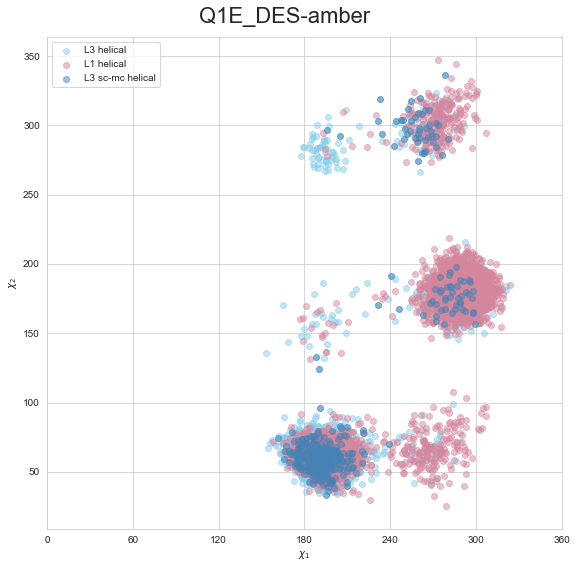

In [37]:
plt.figure(figsize=(8,8))
plt.suptitle('Q1E_DES-amber', fontsize=22)
plt.scatter(chis1_L3_helix[:,0],chis2_L3_helix[:,0], marker='o', color='skyblue', label="L3 helical", alpha=0.5) 
plt.scatter(chis1_L1_helix[:,0],chis2_L1_helix[:,0], color='#d5869d', marker='o', label="L1 helical", alpha=0.5) 
plt.scatter(chis1_L3_hhbond[:,0],chis2_L3_hhbond[:,0],color='steelblue', marker='o', label="L3 sc-mc helical", alpha=0.5 )
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend(loc='best')
plt.tight_layout()
plt.xticks(angles)

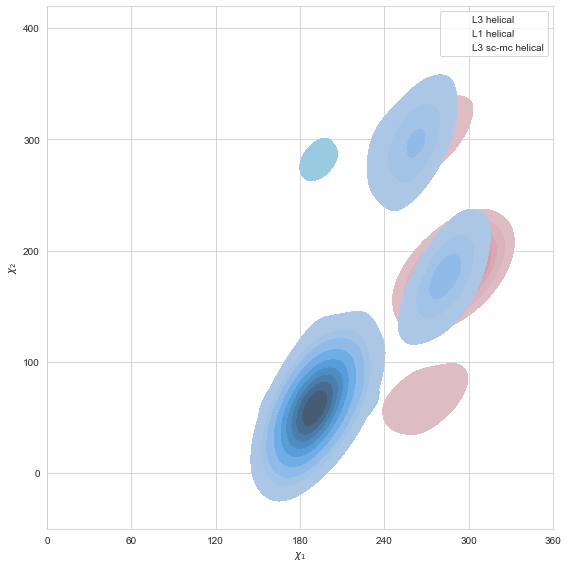

In [38]:
plt.figure(figsize=(8,8))
sns.kdeplot(x=chis1_L3_helix[:,0],y=chis2_L3_helix[:,0], color='skyblue', shade='fill', label="L3 helical") 
sns.kdeplot(x=chis1_L1_helix[:,0],y=chis2_L1_helix[:,0], color='#d5869d',  shade='fill', label="L1 helical") 
sns.kdeplot(x=chis1_L3_hhbond[:,0],y=chis2_L3_hhbond[:,0], color='steelblue', shade='fill', label="L3 sc-mc helical" )
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend(loc='best')
plt.xticks(angles)
plt.tight_layout()


In [13]:
chis1_L3_helix = list(chis1_L3_helix[:,0])
chis1_L1_helix = list(chis1_L1_helix[:,0])
chis1_L3_hhbond = list(chis1_L3_hhbond[:,0])

chis2_L3_helix = list(chis2_L3_helix[:,0])
chis2_L1_helix = list(chis2_L1_helix[:,0])
chis2_L3_hhbond = list(chis2_L3_hhbond[:,0])


In [39]:
import collections

#Creating a disctionary where the keys are the different rotamer annotations and the values are the number of times each
#rotamer appears in the trajectory

# DICTIONARY FOR HELICAL L1

i = 0
j = 0
L1_helix_rotamers = []

for i,j in zip(chis1_L1_helix,chis2_L1_helix):
    if i <=120 and j<=120:
        rot = "g+g+"
        L1_helix_rotamers.append(rot)
    elif i<= 120 and (j>120 and j<=240):
        rot = "g+t"
        L1_helix_rotamers.append(rot)
    elif i<= 120 and (j>240 and j<=360):
        rot = "g+g-"
        L1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and j<=120:
        rot = "tg+"
        L1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and (j>120 and j<=240):
        rot = "tt"
        L1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and (j>240 and j<=360):
        rot = "tg-"
        L1_helix_rotamers.append(rot)
    elif (i>240 and i<=360) and (j<=120):
        rot = "g-g+"
        L1_helix_rotamers.append(rot)
    elif (i>240 and i<=360) and (j>120 and j<=240):
        rot = "g-t"
        L1_helix_rotamers.append(rot)
    else:
        rot = "g-g-"
        L1_helix_rotamers.append(rot)

df_L1_helix = pd.DataFrame(list(zip(chis1_L1_helix,chis2_L1_helix,L1_helix_rotamers)), 
          columns=['chis1','chis2','r1r2RotamersPopulation'])
print (df_L1_helix)


L1_helix_RotCount = collections.Counter(L1_helix_rotamers)
print (L1_helix_RotCount)

L1_helix_RotCount['g+g+'] = 0
L1_helix_RotCount['g+t'] = 0
L1_helix_RotCount['g+g-'] = 0
print("Updated Dict is: ", L1_helix_RotCount)

L1_helix_RotDict = dict(L1_helix_RotCount)
L1_helix_RotSort = dict(sorted(L1_helix_RotDict.items()))

print (L1_helix_RotSort)


            chis1        chis2 r1r2RotamersPopulation
0     [204.55463]    [66.7456]                    tg+
1     [191.46478]    [51.9942]                    tg+
2      [285.7146]  [155.53873]                    g-t
3     [289.65198]   [157.7326]                    g-t
4      [282.7031]  [195.42824]                    g-t
...           ...          ...                    ...
4315  [183.56372]   [57.49435]                    tg+
4316  [187.75476]  [55.580948]                    tg+
4317  [271.53217]  [308.53833]                   g-g-
4318   [273.3964]   [301.3568]                   g-g-
4319   [261.9701]  [317.01074]                   g-g-

[4320 rows x 3 columns]
Counter({'g-t': 2770, 'tg+': 1131, 'g-g-': 206, 'g-g+': 182, 'tt': 22, 'tg-': 9})
Updated Dict is:  Counter({'g-t': 2770, 'tg+': 1131, 'g-g-': 206, 'g-g+': 182, 'tt': 22, 'tg-': 9, 'g+g+': 0, 'g+t': 0, 'g+g-': 0})
{'g+g+': 0, 'g+g-': 0, 'g+t': 0, 'g-g+': 182, 'g-g-': 206, 'g-t': 2770, 'tg+': 1131, 'tg-': 9, 'tt': 22}


In [24]:
# DICTIONARY FOR HELICAL L3

k = 0
l = 0
L3_helix_rotamers = []

for k,l in zip(chis1_L3_helix,chis2_L3_helix):
    if k <=120 and l<=120:
        rot2 = "g+g+"
        L3_helix_rotamers.append(rot2)
    elif k<= 120 and (l>120 and l<=240):
        rot2 = "g+t"
        L3_helix_rotamers.append(rot2)
    elif k<= 120 and (l>240 and l<=360):
        rot2 = "g+g-"
        L3_helix_rotamers.append(rot2)
    elif (k>120 and k<=240) and l<=120:
        rot2 = "tg+"
        L3_helix_rotamers.append(rot2)
    elif (k>120 and k<=240) and (l>120 and l<=240):
        rot2 = "tt"
        L3_helix_rotamers.append(rot2)
    elif (k>120 and k<=240) and (l>240 and l<=360):
        rot2 = "tg-"
        L3_helix_rotamers.append(rot2)
    elif (k>240 and k<=360) and (l<=120):
        rot2 = "g-g+"
        L3_helix_rotamers.append(rot2)
    elif (k>240 and k<=360) and (l>120 and l<=240):
        rot2 = "g-t"
        L3_helix_rotamers.append(rot2)
    else:
        rot2 = "g-g-"
        L3_helix_rotamers.append(rot2)

df_L3_helix = pd.DataFrame(list(zip(chis1_L3_helix,chis2_L3_helix,L3_helix_rotamers)), 
                  columns=['chis1','chis2','r1r2RotamersPopulation'])
print (df_L3_helix)

L3_helix_RotCount = collections.Counter(L3_helix_rotamers)
print (L3_helix_RotCount)

L3_helix_RotCount['g+g+'] = 0
L3_helix_RotCount['g+t'] = 0
L3_helix_RotCount['g+g-'] = 0
print("Updated Dict is: ", L3_helix_RotCount)

L3_helix_RotDict = dict(L3_helix_RotCount)
L3_helix_RotSort = dict(sorted(L3_helix_RotDict.items()))

print (L3_helix_RotSort)



           chis1      chis2 r1r2RotamersPopulation
0     205.150543  67.322433                    tg+
1     190.589462  52.557590                    tg+
2     191.027481  53.214401                    tg+
3     186.310760  52.036301                    tg+
4     204.858109  78.083961                    tg+
...          ...        ...                    ...
4315  188.847137  64.756638                    tg+
4316  176.817703  50.020275                    tg+
4317  170.912140  63.954624                    tg+
4318  188.642090  52.248486                    tg+
4319  185.333191  75.438103                    tg+

[4320 rows x 3 columns]
Counter({'tg+': 3431, 'g-t': 664, 'g-g-': 100, 'tg-': 61, 'g-g+': 34, 'tt': 30})
Updated Dict is:  Counter({'tg+': 3431, 'g-t': 664, 'g-g-': 100, 'tg-': 61, 'g-g+': 34, 'tt': 30, 'g+g+': 0, 'g+t': 0, 'g+g-': 0})
{'g+g+': 0, 'g+g-': 0, 'g+t': 0, 'g-g+': 34, 'g-g-': 100, 'g-t': 664, 'tg+': 3431, 'tg-': 61, 'tt': 30}


In [26]:
# DICTIONARY FOR Hydrogen Bond Forming Q1

e = 0
f = 0
L3_hhbond_rotamers = []

for e,f in zip(chis1_L3_hhbond,chis2_L3_hhbond):
    if e<=120 and f<=120:
        rot3 = "g+g+"
        L3_hhbond_rotamers.append(rot3)
    elif e<= 120 and (f>120 and f<=240):
        rot3 = "g+t"
        L3_hhbond_rotamers.append(rot3)
    elif e<= 120 and (f>240 and f<=360):
        rot3 = "g+g-"
        L3_hhbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and f<=120:
        rot3 = "tg+"
        L3_hhbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and (f>120 and f<=240):
        rot3 = "tt"
        L3_hhbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and (f>240 and f<=360):
        rot3 = "tg-"
        L3_hhbond_rotamers.append(rot3)
    elif (e>240 and e<=360) and (f<=120):
        rot3 = "g-g+"
        L3_hhbond_rotamers.append(rot3)
    elif (e>240 and e<=360) and (f>120 and f<=240):
        rot3 = "g-t"
        L3_hhbond_rotamers.append(rot3)
    else:
        rot3 = "g-g-"
        L3_hhbond_rotamers.append(rot3)

# Dataframe 
df_hbond = pd.DataFrame(list(zip(chis1_L3_hhbond,chis2_L3_hhbond,L3_hhbond_rotamers)), 
                  columns=['chis1','chis2','r1r2RotamersPopulation'])
print (df_hbond)


L3_hhbond_RotCount = collections.Counter(L3_hhbond_rotamers)
print (L3_hhbond_RotCount)

# This should be modified and get it into  a conditional loop that would be able to check if the dictionary presents 
#all the nine different rotamers population and if not, then add all they are missing
L3_hhbond_RotCount['g+g+'] = 0
L3_hhbond_RotCount['g+g-'] = 0
L3_hhbond_RotCount['g+t'] = 0
L3_hhbond_RotCount['g-g+'] = 0


#print("Updated Dict is: ", L3_hhbond_RotCount)

L3_hhbond_RotDict = dict(L3_hhbond_RotCount)
L3_hhbond_RotSort = dict(sorted(L3_hhbond_RotDict.items()))

print(L3_hhbond_RotSort)




          chis1      chis2 r1r2RotamersPopulation
0    175.748260  67.120445                    tg+
1    192.818497  47.640869                    tg+
2    195.445786  65.136253                    tg+
3    173.780533  55.712502                    tg+
4    184.074875  58.023388                    tg+
..          ...        ...                    ...
451  174.875107  56.629826                    tg+
452  205.572952  58.590385                    tg+
453  170.095505  63.164337                    tg+
454  170.912140  63.954624                    tg+
455  185.333191  75.438103                    tg+

[456 rows x 3 columns]
Counter({'tg+': 361, 'g-t': 46, 'g-g-': 41, 'tg-': 5, 'tt': 3})
{'g+g+': 0, 'g+g-': 0, 'g+t': 0, 'g-g+': 0, 'g-g-': 41, 'g-t': 46, 'tg+': 361, 'tg-': 5, 'tt': 3}


Text(0, 0.5, 'Total Number')

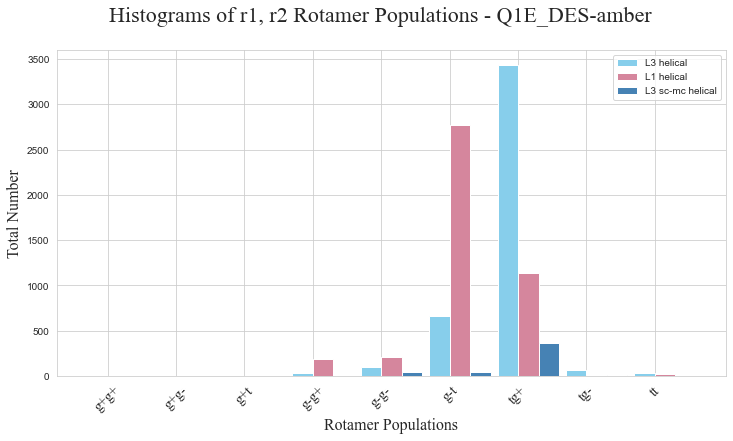

In [27]:
fig = plt.figure(figsize=(12,6)) 
sns.set_style('whitegrid')
ind = np.arange(9)
width = 0.30  
categories = ['g+g+','g+g-','g+t','g-g+','g-g-','g-t','tg+','tg-','tt']
csfont = {'fontname':'Times New Roman'}

plt.bar(ind, L3_helix_RotSort.values(), width, label="L3 helical", color="skyblue", align="edge")
plt.bar(ind+width, L1_helix_RotSort.values(), width, label="L1 helical", color="#d5869d", align="edge")
plt.bar(ind+2*width, L3_hhbond_RotSort.values(), width, label="L3 sc-mc helical", color="steelblue", align="edge")
plt.xticks(ind + width, categories, fontsize=14, rotation=45, **csfont)
plt.legend(loc="best")
fig.suptitle('Histograms of r1, r2 Rotamer Populations - Q1E_DES-amber', fontsize=22, **csfont)
plt.xlabel('Rotamer Populations', fontsize=16, **csfont)
plt.ylabel('Total Number', fontsize=16, **csfont)


Now, it would be a good approach to study the total pertentaje of each r1r2 rotamers (depending on the secondary structure it addopts) instead of the total number. 

In [29]:
# Function to modify each value of the dictionary
def mutate_dict(f,d):
    for k, v in d.items():
        d[k] = f(v)

#We want to 

# Helical L3 
values_L3 = L3_helix_RotSort.values()
print(values_L3)
factor1 = 100/sum(values_L3)
print(factor1)

mutate_dict(lambda x: x*factor1, L3_helix_RotSort)
print (L3_helix_RotSort)
    

#Helical L1
values_L1 = L1_helix_RotSort.values()
print(values_L1)
factor2 = 100/sum(values_L1)
print(factor2)

mutate_dict(lambda x: x*factor2, L1_helix_RotSort)
print (L1_helix_RotSort)


# L3 forming a sc-mc hydrogen bond with Q3
values_L3_hhbond = L3_hhbond_RotSort.values()
print(values_L3_hhbond)
factor3 = 100/sum(values_L3_hhbond)
print(factor3)

mutate_dict(lambda x: x*factor3, L3_hhbond_RotSort)
print (L3_hhbond_RotSort)

dict_values([0, 0, 0, 34, 100, 664, 3431, 61, 30])
0.023148148148148147
{'g+g+': 0.0, 'g+g-': 0.0, 'g+t': 0.0, 'g-g+': 0.787037037037037, 'g-g-': 2.314814814814815, 'g-t': 15.37037037037037, 'tg+': 79.42129629629629, 'tg-': 1.412037037037037, 'tt': 0.6944444444444444}
dict_values([0, 0, 0, 182, 206, 2770, 1131, 9, 22])
0.023148148148148147
{'g+g+': 0.0, 'g+g-': 0.0, 'g+t': 0.0, 'g-g+': 4.212962962962963, 'g-g-': 4.768518518518518, 'g-t': 64.12037037037037, 'tg+': 26.180555555555554, 'tg-': 0.20833333333333331, 'tt': 0.5092592592592592}
dict_values([0, 0, 0, 0, 41, 46, 361, 5, 3])
0.21929824561403508
{'g+g+': 0.0, 'g+g-': 0.0, 'g+t': 0.0, 'g-g+': 0.0, 'g-g-': 8.991228070175438, 'g-t': 10.087719298245613, 'tg+': 79.16666666666666, 'tg-': 1.0964912280701753, 'tt': 0.6578947368421052}


Text(0, 0.5, 'Percent of total')

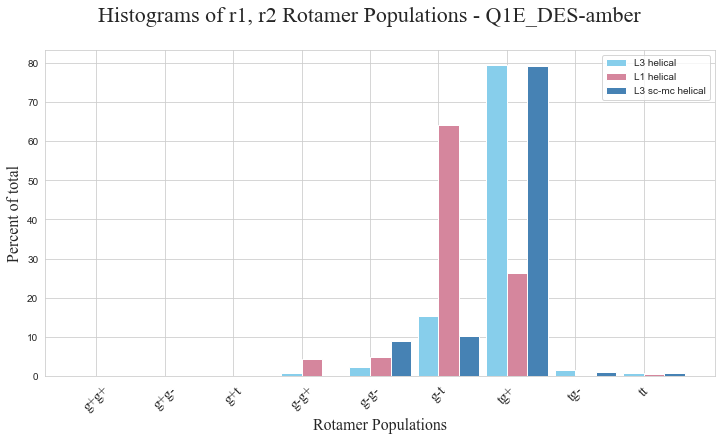

In [30]:
fig = plt.figure(figsize=(12,6)) 
sns.set_style('whitegrid')
ind = np.arange(9)
width = 0.30  
categories = ['g+g+','g+g-','g+t','g-g+','g-g-','g-t','tg+','tg-','tt']
csfont = {'fontname':'Times New Roman'}

plt.bar(ind, L3_helix_RotSort.values(), width, label="L3 helical", color="skyblue", align="edge")
plt.bar(ind+width, L1_helix_RotSort.values(), width, label="L1 helical", color="#d5869d", align="edge")
plt.bar(ind+2*width, L3_hhbond_RotSort.values(), width, label="L3 sc-mc helical", color="steelblue", align="edge")
plt.xticks(ind + width, categories, fontsize=14, rotation=45, **csfont)
plt.legend(loc="best")
fig.suptitle('Histograms of r1, r2 Rotamer Populations - Q1E_DES-amber', fontsize=22, **csfont)
plt.xlabel('Rotamer Populations', fontsize=16, **csfont)
plt.ylabel('Percent of total', fontsize=16, **csfont)

### r3 Kernel Density Analysis

#### The backbone-independent distribution of nonrotameric χ3 of Gln for each of its (χ1, χ2) rotamers. 

Nonrotameric χ3 distributions for Gln are dependent on both the χ1 and χ2 rotamers. The distributions of the nonrotameric degrees of freedom are very broad and asymmetric and cannot be modeled with a rotameric model (Shapovalov & Dunbrack Jr, 2011)

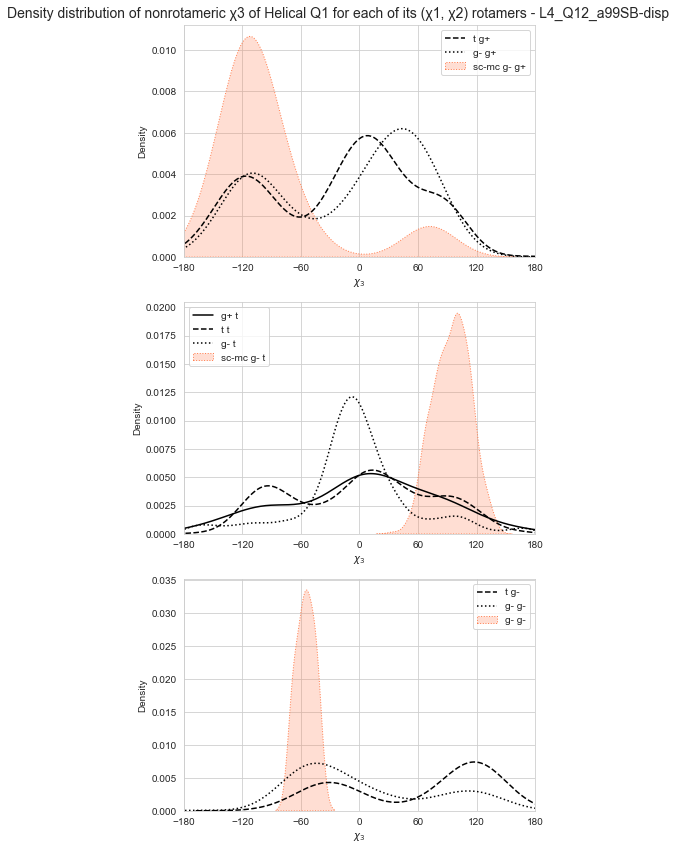

In [50]:
# We are going to use the created dataframes for each Gln condition

# HELICAL Q1 --> dataframe = df_helix

plt.figure(figsize=(6,12)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Helical Q1 for each of its (χ1, χ2) rotamers - L4_Q12_a99SB-disp', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+g+"'), x="chi3_1H", linestyle="-", label="g+ g+", color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tg+"'), x="chi3_1H", linestyle="--", label="t g+",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-g+"'), x="chi3_1H", linestyle=":", label="g- g+",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g+"'), x="chi3_1_HH", linestyle=":", label="sc-mc g- g+",color="coral",shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+t"'), x="chi3_1H", linestyle="-", label="g+ t", color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g+t"'), x="chi3_1_HH", linestyle="-", label="sc-mc g+ t", color="coral",shade=True)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tt"'), x="chi3_1H", linestyle="--", label="t t",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1H", linestyle=":", label="g- t",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1_HH", linestyle=":", label="sc-mc g- t",color="coral",shade=True)
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+g-"'), x="chi3_1H", linestyle="-", label="g+ g-",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tg-"'), x="chi3_1H", linestyle="--", label="t g-",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_1H", linestyle=":", label="g- g-",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_1_HH", linestyle=":", label="g- g-",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()

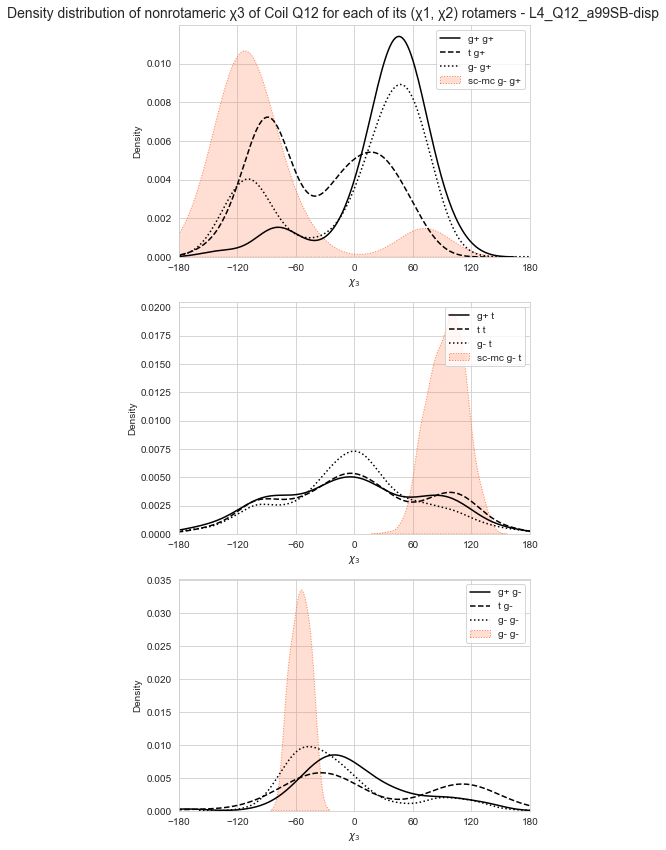

In [51]:
# We are going to use the created dataframes for each Gln condition

# COIL Q12 --> dataframe = df_coil

plt.figure(figsize=(6,12)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Coil Q12 for each of its (χ1, χ2) rotamers - L4_Q12_a99SB-disp', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+g+"'), x="chi3_12C", linestyle="-", label="g+ g+", color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tg+"'), x="chi3_12C", linestyle="--", label="t g+",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-g+"'), x="chi3_12C", linestyle=":", label="g- g+",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g+"'), x="chi3_1_HH", linestyle=":", label="sc-mc g- g+",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+t"'), x="chi3_12C", linestyle="-", label="g+ t", color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tt"'), x="chi3_12C", linestyle="--", label="t t",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-t"'), x="chi3_12C", linestyle=":", label="g- t",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1_HH", linestyle=":", label="sc-mc g- t",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+g-"'), x="chi3_12C", linestyle="-", label="g+ g-",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tg-"'), x="chi3_12C", linestyle="--", label="t g-",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_12C", linestyle=":", label="g- g-",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_1_HH", linestyle=":", label="g- g-",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()

/home/lourdes/miniconda3/envs/TFM/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/lourdes/miniconda3/envs/TFM/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


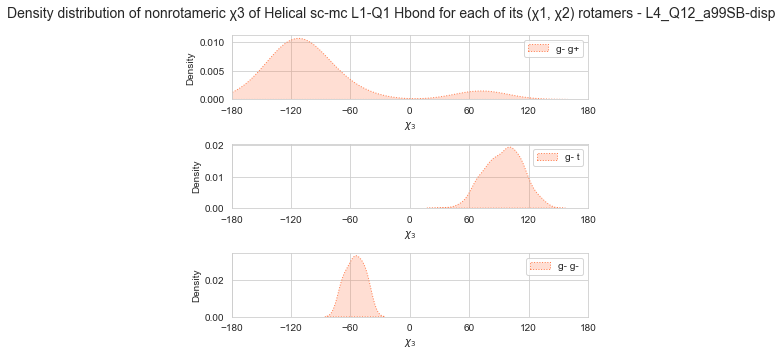

In [52]:
plt.figure(figsize=(6,5)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Helical sc-mc L1-Q1 Hbond for each of its (χ1, χ2) rotamers - L4_Q12_a99SB-disp', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g+g+"'), x="chi3_1_HH", linestyle="-", label="g+ g+", color="coral", shade=True)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "tg+"'), x="chi3_1_HH", linestyle="--", label="t g+",color="coral", shade=True)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g+"'), x="chi3_1_HH", linestyle=":", label="g- g+",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g+t"'), x="chi3_1_HH", linestyle="-", label="g+ t", color="coral", shade=True)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "tt"'), x="chi3_1_HH", linestyle="--", label="t t",color="coral", shade=True)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1_HH", linestyle=":", label="g- t",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g+g-"'), x="chi3_1_HH", linestyle="-", label="g+ g-",color="coral", shade=True)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "tg-"'), x="chi3_1_HH", linestyle="--", label="t g-",color="coral", shade=True)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_1_HH", linestyle=":", label="g- g-",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()

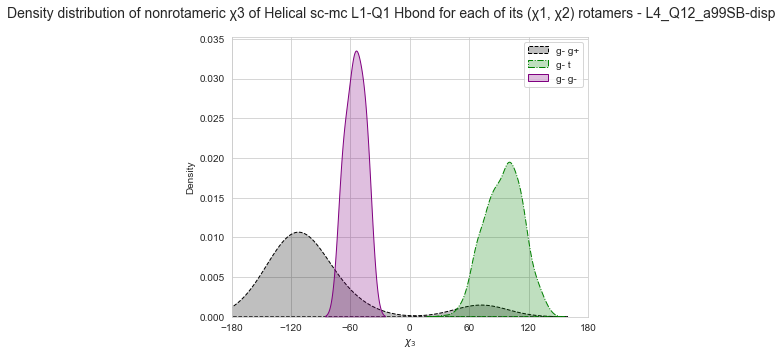

In [53]:
# HELICAL Q1 & L1-Q1 hbond --> dataframe = df_hbond

plt.figure(figsize=(6,5)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Helical sc-mc L1-Q1 Hbond for each of its (χ1, χ2) rotamers - L4_Q12_a99SB-disp', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g+"'), x="chi3_1_HH", linestyle="--", label="g- g+",color="k", shade=True)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1_HH", linestyle="-.", label="g- t",color="g", shade=True)
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_1_HH", linestyle="-", label="g- g-",color="purple", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)


plt.tight_layout()